# Interactive and Explainable AI 

Here, we will study the implementation of tools for interactive GAN exploration by Zhang and Banovic (2021) that we covered in the first part of the lecture. However, this is by no means an optimized version; here, we are happy to tradeoff performance for even a smallest gain in clarity. Also note that this notebook is <strong>not</strong> the full implementation of GAN Explorer from that paper. To implement the full web-based tool would require placing the code from this notebook onto a Webserver, connecting it with a database that will permantenly store the data for each individual user, and implementing client side user interface.

With that said, let's start.

In [1]:
# For utility operations
import sys
import os 

# For vectror and matrix operations, and sampling.
import math
import numpy as np
np.set_printoptions(threshold=sys.maxsize)
import random
from scipy.stats import truncnorm

# For drawing images and graphs
import matplotlib.pyplot as plt

# BigGAN model
import torch
import nltk
from pytorch_pretrained_biggan import (BigGAN, BigGANConfig, one_hot_from_names, truncated_noise_sample, save_as_images)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/nbanovic/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/nbanovic/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [3]:
def get_emptiest_gpu():
    # Command line to find memory usage of GPUs. Return the one with most mem available.
    output = os.popen('nvidia-smi -q -d Memory | grep -A4 GPU | grep Free').read().strip()
    mem_avail = [int(x.split()[2]) for x in output.split('\n')]
    return mem_avail.index(max(mem_avail))

if torch.cuda.is_available():
    torch.cuda.set_device(get_emptiest_gpu())

device = torch.device('cuda' if torch.cuda.is_available() else "cpu")

## Model

For our interactive model exploration, we will be using a pre-trained BigGAN model. For more information about the API that we will use to access the model see: https://github.com/huggingface/pytorch-pretrained-BigGAN.

Remember from the lecture:

- Training a GAN involves two networks:
    - a Generator that takes in a vector of latent variables $z = (𝑧_1, ..., 𝑧_𝑛) ∈ R^𝑛$ and outputs the corresponding image
    - a Discriminator that is used to distinguish between generated images and real images (training data).

- The Generator is trained to maximize the probability of fooling the Discriminator

- The Discriminator is trained to discriminate training data from the images created by the Generator.

Here, we will only be focusing on the generator.

In [4]:
generator = BigGAN.from_pretrained('biggan-deep-128')

## Visualizing Model Output
Now that we have the model, it is time to think about how to assess its capabilities and limitations. One way to explore the model is through qualitative model inspection.

Take a moment to think what is the most basic interaction that we can implement to explore the model?

One such interaction is to visualize the outputs of the model as an image gallery! The function below takes as input a model, a vector of model parameters ($z$), and corresponding image categories, then outputs an image gallery containing images that correspond to those model parameters.

In [5]:
def display_gallery(biggan_G, z_s, categories, rows=5, cols=5, truncation=1):
    
    if rows == 0 or cols == 0:
        return
    
    fig, axs = plt.subplots(rows, cols, figsize=(cols*2, rows*2))

    for i in range(rows):
        for j in range(cols):
            _z = torch.from_numpy(z_s[i * rows + j]).type(torch.float).reshape(1, -1)
            _y = torch.tensor([categories[i * rows + j]])
            _z = _z.to(device)
            _y = _y.to(device)
            output_img_org = biggan_G(_z, _y, truncation)
            output_img = (output_img_org - output_img_org.min()) / (output_img_org.max() - output_img_org.min())
            display_img = output_img.squeeze(0).permute(1, 2, 0).cpu().detach().numpy()
            display_img = (display_img * 255).astype(np.uint8)
            if rows > 1:
                axs[i, j].imshow(display_img)
                axs[i, j].axis("off")   # turns off axes
                axs[i, j].axis("tight")  # gets rid of white border
            elif rows == 1 and cols == 1:
                # Single image "gallery".
                axs.imshow(display_img)
                axs.axis("off")   # turns off axes
                axs.axis("tight")  # gets rid of white border
            else:
                # Single row gallery.
                axs[j].imshow(display_img)
                axs[j].axis("off")   # turns off axes
                axs[j].axis("tight")  # gets rid of white border

    plt.show()

Execute the cell below a few times (each time you should get a different output). Feel free to change the parameters (e.g., the truncation, the names of image categories that you want to generate).

Answer these questions:
- What happens as you increase truncation up to 1?
- What happens as you reduce truncation down to 0?

/var/folders/5g/b_09k2450cd2py76m28clrgc0000gp/T/ipykernel_98319/638731080.py:11: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /Users/distiller/project/pytorch/torch/csrc/utils/tensor_new.cpp:210.)
  _y = torch.tensor([categories[i * rows + j]])


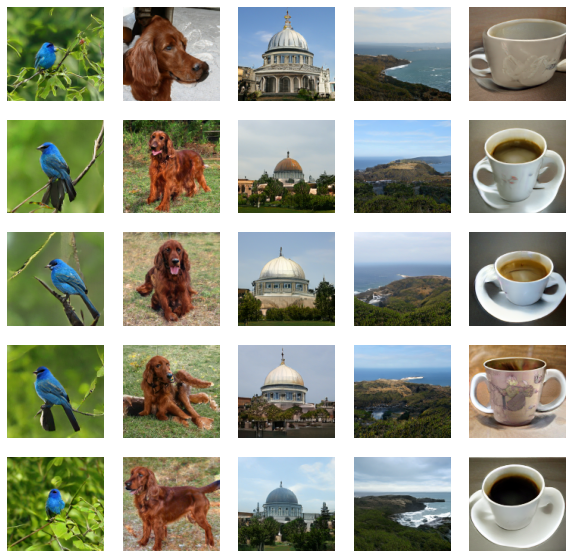

In [6]:
truncation = 0.5
class_vector = one_hot_from_names(['indigo finch','irish setter','dome','headland','cup']*5, batch_size=25)
z_vectors = truncated_noise_sample(truncation=truncation, batch_size=25)
display_gallery(generator, z_vectors, class_vector)

You may say that such an image gallery is not very interactive; and you'd be right. Though, that is what most model designers currently use when investigating their GANs.

Let's see if we can make our image gallery more interactive.

## Interactive GAN Model Exploration
Here, we will explore the concept of an image gallery that will provide the user with a "lens" onto our model. Our image gallery displays $n \times n$ GAN-generated images organized in a grid. The user can then interact with the image gallery to "move" this lens from one region of the model to another to map out regions where the model generates high-quality images and other regions where the quality of images is not as good.

Here, we draw inspiration from existing work (Koyama et al., 2020) to mathematically formalize the current working gallery as a square region of a 2D plane $\mathcal{P}$. We uniquely define plane region $\mathcal{P}$ in a hyperspace with three vectors $\mathbf{c}$, $\mathbf{u}$, $\mathbf{v}$, where $\mathbf{c}$ is the center of the region of the plane, and $\mathbf{u}$ and $\mathbf{v}$ are two orthogonal vectors with equal length on the plane that both point from the center $\mathbf{c}$.

Note that the number of dimensions of each vector $\mathbf{c}$, $\mathbf{u}$, $\mathbf{v}$ corresponds to the number of dimensions of the vector of latent variables $\mathbf{z}$ that the GAN takes as input. We then represent the images in the current working gallery as $n$ equally-spaced data points on the plane region, denoted by a set of vectors of latent variables $Z=\{\mathbf{z_1,z_2,...,z_{n}}\}$, where each vector of latent variables $\mathbf{z_i}\in{Z}$ is an input to the GAN model with the corresponding image as output.

Image below shows an example square plane region $\mathcal{P}$ containing twenty five equally-spaced data points (denoted by a set of vectors of latent variables $Z=\{\mathbf{z_1,z_2,...,z_{25}}\}$).

<div>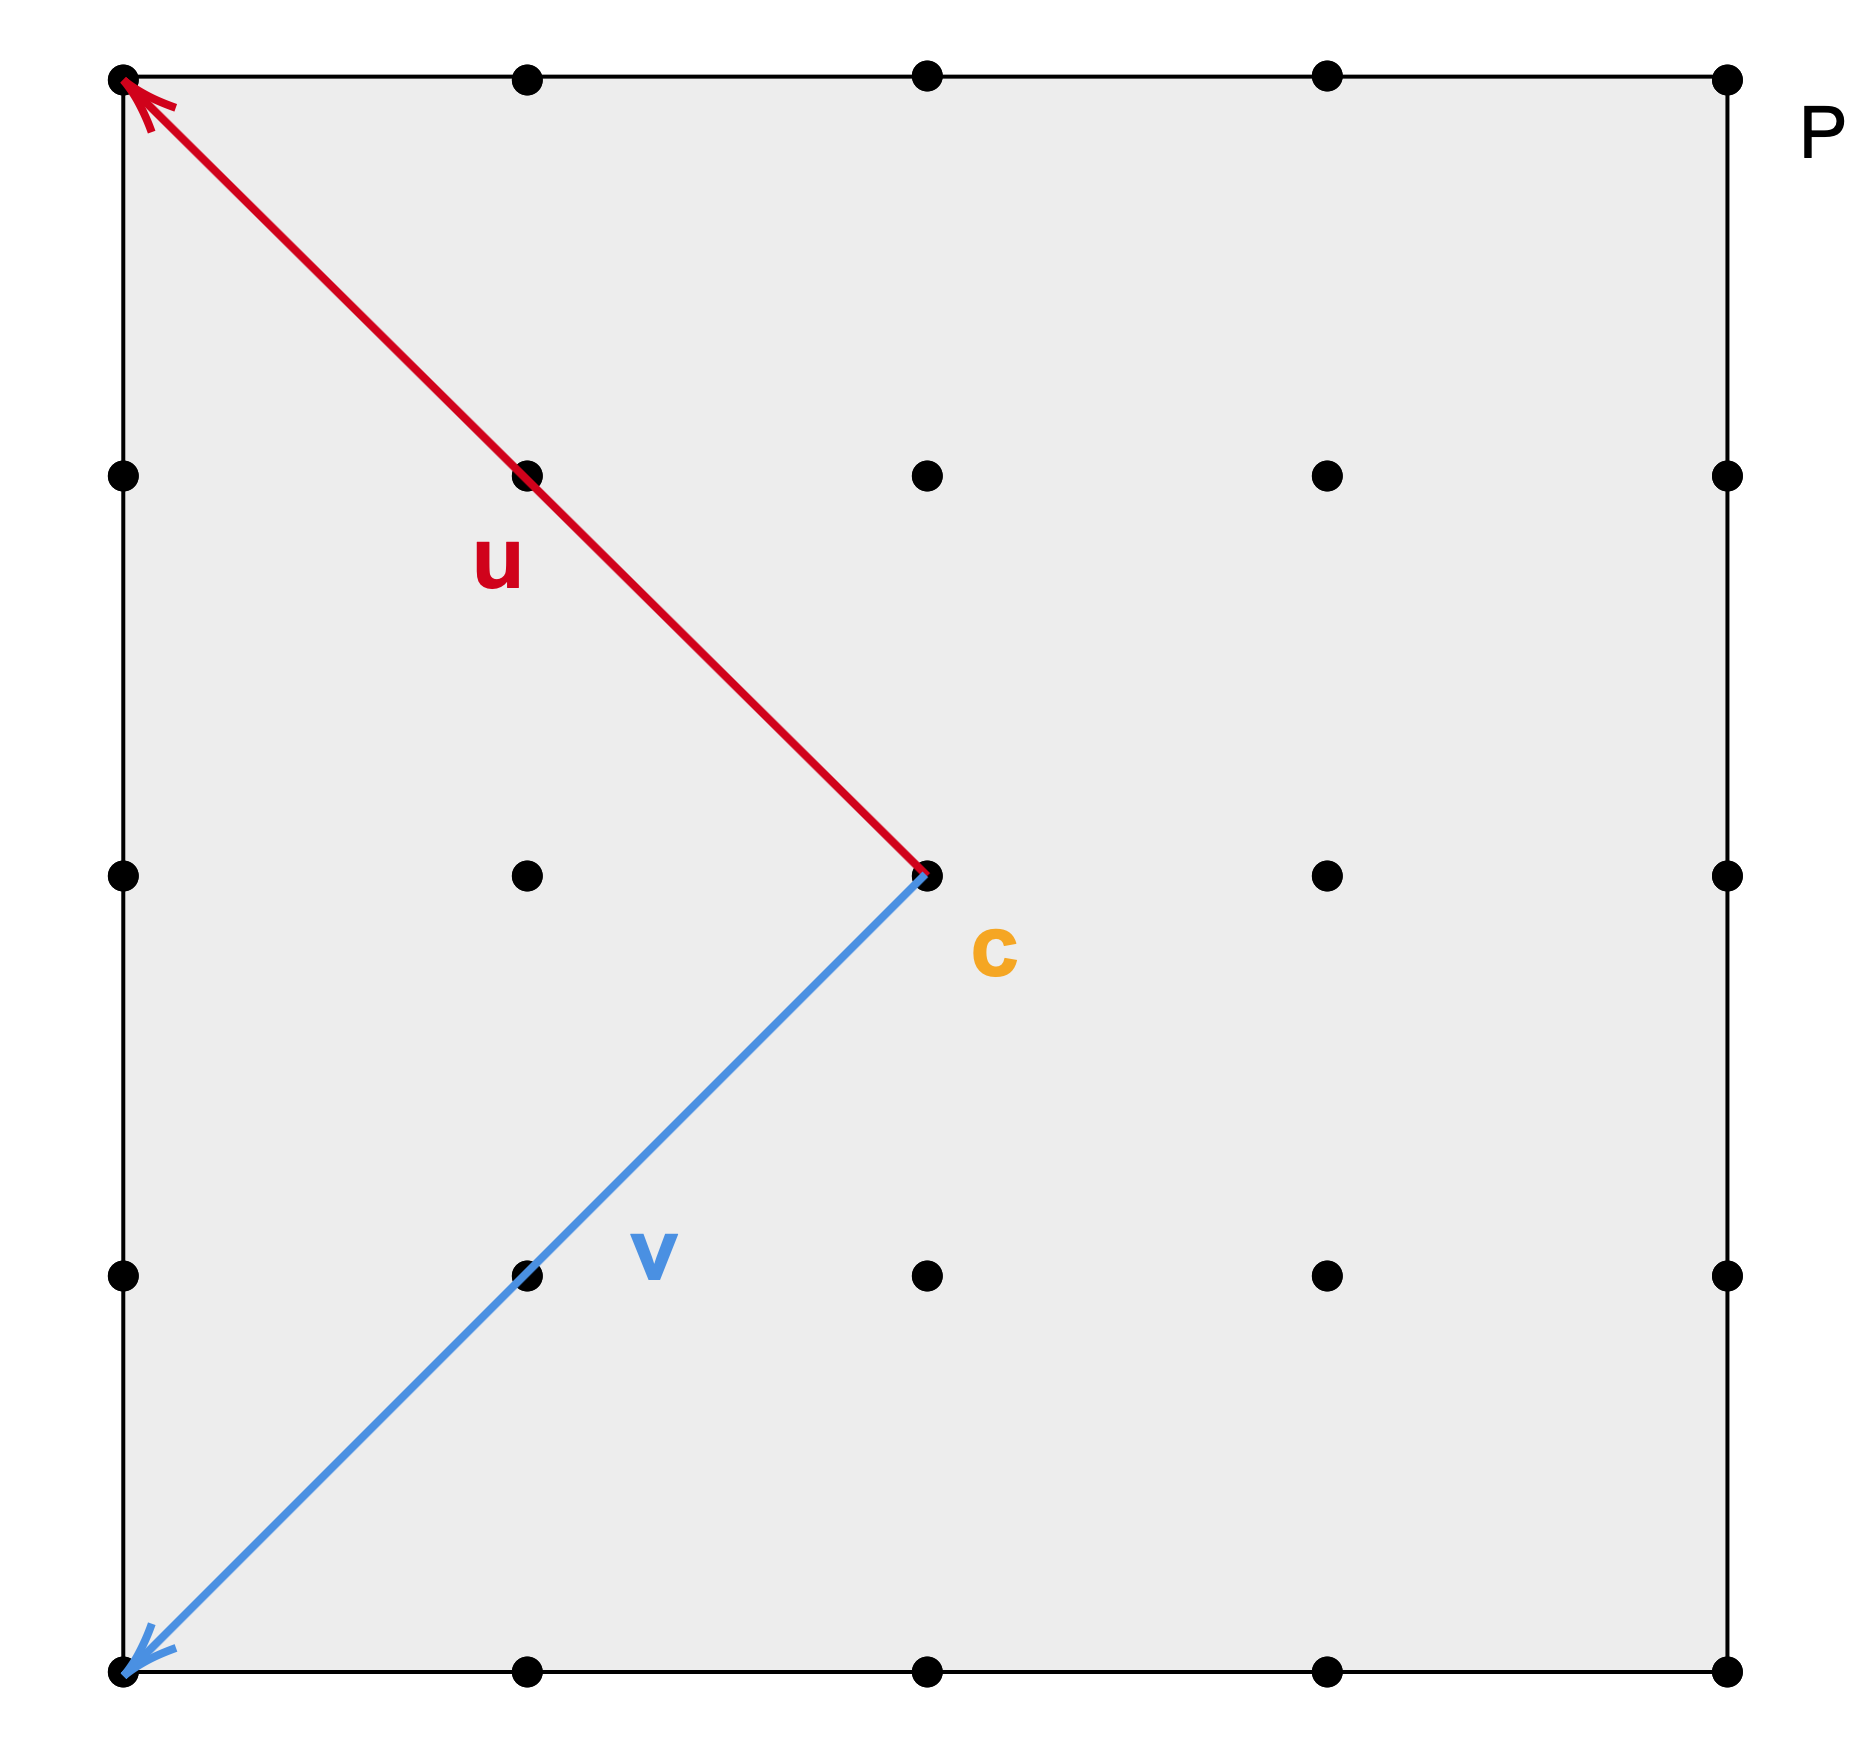</div>

Let's initialize one such image gallery and see how that looks in the code!

In [7]:
def sampling_from_plane(c, u, v, num_dims = 10, rows=5, cols=5, base=10):
    '''
    Return rows x cols sampling points from the given plane, paremeterized by (c,u,v).
    
    Args:
        c: center point of the plane.
        u: vector u.
        v: vector v, which is orthogonal to u.

    Returns:
        sampling_points: shape: (rows x cols). Each row is a sampling point.
    '''
    vec_len = base / (1.2 ** zoom_level)
    
    u = vec_len * u / np.linalg.norm(u)
    v = vec_len * v / np.linalg.norm(v)
    
    c = c.reshape(-1)
    u = u.reshape(-1)
    v = v.reshape(-1)
    
    row_step = (v - u) / 4
    col_step = (-1 * v - u) / 4
    start_point = c - 2 * row_step - 2 * col_step
    sampling_points = np.zeros((rows * cols, num_dims))
    for i in range(rows):
        for j in range(cols):
            sampling_points[i * rows + j] = start_point + row_step * i + col_step * j
    return sampling_points

In [8]:
def compute_z_vectors(sampling_points, base_vector, tune_idxs, rows = 5, cols = 5):
    z_vectors = []
    for i in range(rows):
        for j in range(cols):
            real_point = np.copy(base_vector)
            real_point[tune_idxs] = sampling_points[i * rows + j]
            z_vectors.append(real_point)
    return np.asarray(z_vectors)

def compute_sampling_points(z_vectors, tune_idxs, rows = 5, cols = 5):
    return np.apply_along_axis((lambda x: x[tune_idxs]), 1, z_vectors)

def get_index_of(row, col, rows=5, cols=5):
    return (row-1) * rows + (col - 1)

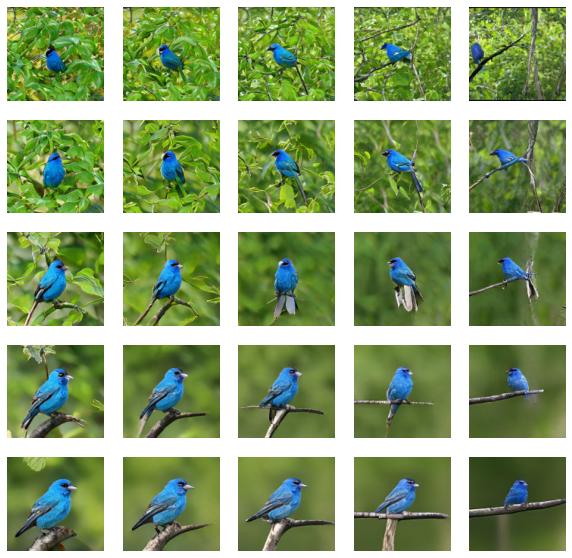

In [9]:
z_len = generator.config.z_dim
zoom_level=0 
num_dims = 10
iteration = 0
tune_idxs = np.random.choice(z_len, num_dims, replace=False)
tune_idxs.sort()

category = 'indigo finch'

# Saved snapshots saved by category and name.
snapshots = {}

# Lists of user selected samples keyed by category.
select_samples = {}

class_vector = one_hot_from_names([category]*25, batch_size=25)

# Initialize plane P_1
# Always start with the "most representative" example of the class in the center.
base_vector = np.zeros(z_len)

c = base_vector[tune_idxs]

v_subset = np.random.randn(num_dims)
v_subset /= np.linalg.norm(v_subset)

u_subset = np.random.randn(num_dims)
u_subset -= u_subset.dot(v_subset) * v_subset
u_subset /= np.linalg.norm(u_subset)

sampling_points = sampling_from_plane(c, u_subset, v_subset)

z_vectors = compute_z_vectors(sampling_points, base_vector, tune_idxs)

display_gallery(generator, z_vectors, class_vector)

Now that we have our image gallery, let's implement some interactions...

### Randomize
Randomizing the current image gallery will simply generate a new working gallery. This is similar to how existing methods generate image galleries and it is not too exciting. However, it is still a useful interaction because it allows the user to start their exploration in a new region of the model that they can stumble upon serendipitously.

In [10]:
def randomize(truncation=0.04, rows=5, cols=5):
    '''
    Reinitializes the current plane segment by randomly selecting a center point and recomputing the other vectors.
    truncation - how far from the most representative sample can the central image be.
    
    rows - used to calculate the number of z_vectors to compute.
    
    cols - used to calculate the number of z_vectors to compute.
    
    Returns a randomly selected z_vectors of size rows x cols.
    '''

    c = truncated_noise_sample(truncation=truncation, batch_size=1)[0][tune_idxs]
    
    v_subset = np.random.randn(len(tune_idxs))
    v_subset /= np.linalg.norm(len(tune_idxs))
    
    u_subset = np.random.randn(len(tune_idxs))
    u_subset -= u_subset.dot(v_subset) * v_subset
    u_subset /= np.linalg.norm(u_subset)

    sampling_points = sampling_from_plane(c, u_subset, v_subset, len(tune_idxs), rows, cols)
    
    z_vectors = compute_z_vectors(sampling_points, base_vector, tune_idxs)
    
    return z_vectors

Let's see what what kind of galleries we can find.

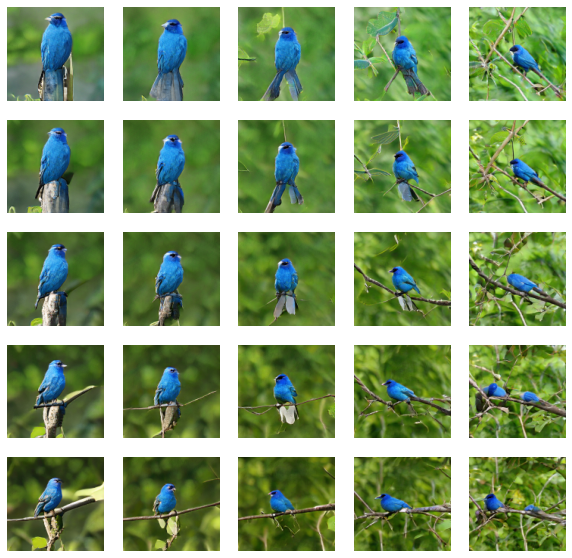

In [11]:
z_vectors = randomize()
display_gallery(generator, z_vectors, class_vector)

Execute the code above a few times and stop when you see a gallery with at least one image that you think is photo-realistic. Feel free to play with the truncation parameter.

## Pivot
Simply restarting the exploration from a random working gallery is not always desirable as it may prevent explorations near the current search space region. To serendipitously explore around the current region of the model, we can "pivot" the current image gallery.

As mentioned earlier, there are 25 images in the current working gallery (each corresponding to a point on the $Z=\{\mathbf{z_1,z_2,...,z_{n}}\}$ in the current plane region $\mathcal{P}$). Each $\mathbf{z_i}\in Z$ has a corresponding vector of latent variables with $m$ dimensions (in our example $m=128$).

We "pivot" by fixing a subset of dimensions in all $n$ latent vectors and changing the values of the remaining dimensions, which results in a new, shifted plane region $\mathcal{P'}$.

In [12]:
def pivot(truncation=0.2, num_dims = 10, rows=5, cols=5):
    # Freeze tuning features in sampling points
    sampling_points = compute_sampling_points(z_vectors, tune_idxs)
    
    # Randomize base vector
    base_vector[:] = truncated_noise_sample(truncation=truncation, batch_size=1)[0]
    
    new_z_vectors = compute_z_vectors(sampling_points, base_vector, tune_idxs)
    
    return new_z_vectors

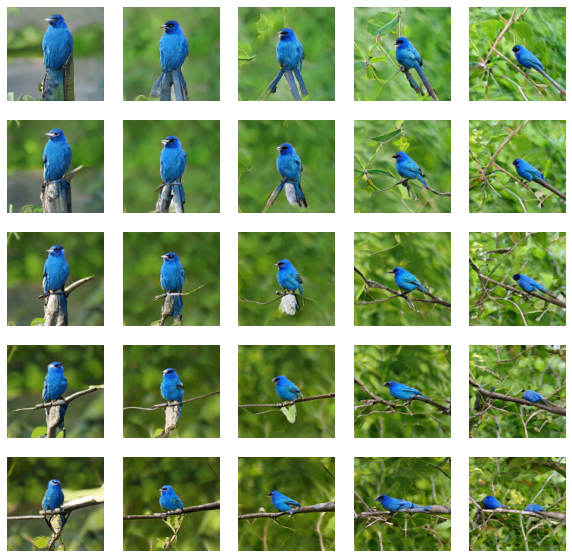

In [13]:
z_vectors = pivot()
display_gallery(generator, z_vectors, class_vector)

Note that despite its user-friendly name that describes the appearance of the effect in the resulting gallery, mathematically, this tool actually shifts the resulting plane region.

### Pan
Up until this point, all of the interactions that we introduced were stochastic --- their output is quite unpredictable. Although this aids in serendipitous exploration of the model, the user might want to have more control over exploring specific regions of the model. 

Note that the current working gallery only shows a region of the current plane 2D, but the plane extends in all four directions. This gives rise to the pan interaction.

Here is the math behing panning to the left (without loss of generality). Let the current working gallery contain $n$ images organized in a $n_{rows} \times n_{cols}$ grid as a set of vectors of latent variables $Z=\{\mathbf{z_1,z_2,...,z_{n}}\}$ on the current plane region $\mathcal{P}$ defined by vectors $\mathbf{c,u,v}$. Let $i$ be the index of the latent vector $z_i$ in the center of the gallery (i.e., $z_i = c$). Then, we can define the following two direction vectors:

1) vector $\mathbf{a}$ points from the top of the gallery to the bottom of the gallery, and

2) vector $\mathbf{b}$ points from gallery's left to gallery's right.


Now, we can compute the resulting plane region $\mathcal{P'}$ defined by $(\mathbf{c',u',v'})$ as:

\begin{equation}
    \mathbf{c'}=\mathbf{z_{i-1}}
\end{equation}

\begin{equation}
    \mathbf{u'}=2(-\mathbf{a}-\mathbf{b})
\end{equation}

\begin{equation}
    \mathbf{v'}=2(\mathbf{a}-\mathbf{b})
\end{equation}

Similarly, it follows that we can pan in the other three directions using a similar way to construct the resulting plane region of the resulting working gallery.

In [14]:
def pan(z_vectors, direction, truncation=0.04, num_dims = 10, rows=5, cols=5):
    sampling_points = compute_sampling_points(z_vectors, tune_idxs)
    
    row_step = sampling_points[rows] - sampling_points[0]
    col_step = sampling_points[1] - sampling_points[0]
    
    center_idx = int(rows * cols / 2)
    new_center_idx = center_idx
    
    if direction == "up":
        new_center_idx = center_idx - cols 
    elif direction == "down":
        new_center_idx = center_idx + cols 
    elif direction == "left":
        new_center_idx = center_idx - 1
    elif direction == "right":
        new_center_idx = center_idx + 1

    c = sampling_points[new_center_idx]
    
    u = -2*row_step-2*col_step
    v = 2*row_step-2*col_step
    
    sampling_points = sampling_from_plane(c, u, v) 
    z_vectors = compute_z_vectors(sampling_points, base_vector, tune_idxs)
    
    return z_vectors

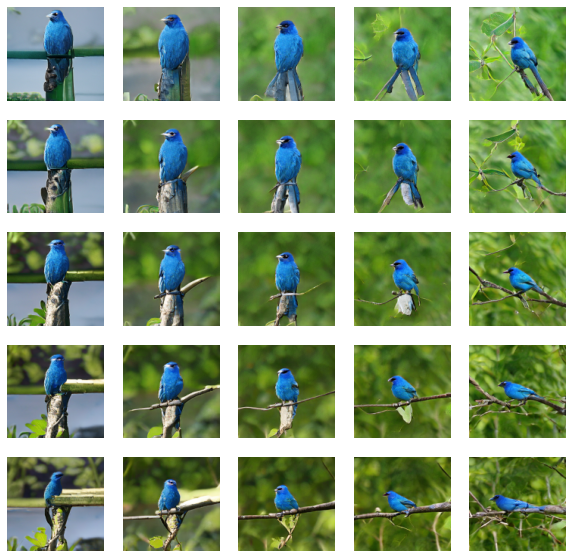

In [15]:
z_vectors = pan(z_vectors, "left")
display_gallery(generator, z_vectors, class_vector)

Execute the code above a few times. Change the direction of pan and stop when you see a gallery with at least one new image that you think is photo-realistic.

### Image Gallery Snapshots
To support user control and freedom, the user should be able to save the current working gallery to restart their exploration from that point at a later time. Here, we provide two snapshot functions to create a new snapshop and revert to an old snapshot. Here is an example:

In [16]:
def create_snapshot(category, name, z_vectors):
    if category not in snapshots:
        snapshots[category] = {}
        
    snapshots[category][name] = z_vectors
        
    return z_vectors

def get_snapshot(category, name):
    return snapshots[category][name]

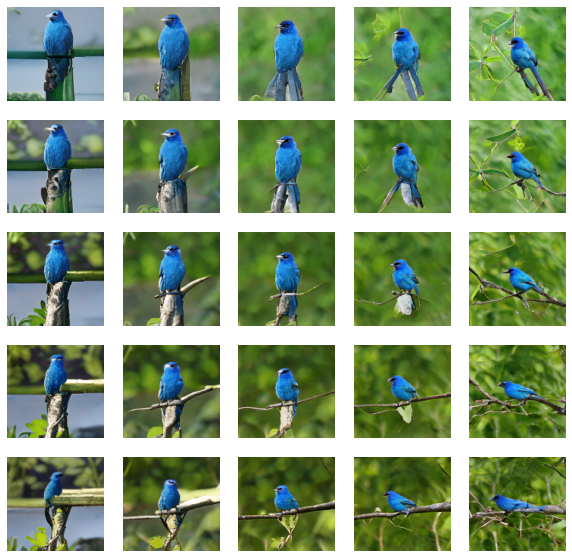

In [17]:
z_vectors = create_snapshot(category, 'snapshot1', z_vectors)
display_gallery(generator, z_vectors, class_vector)

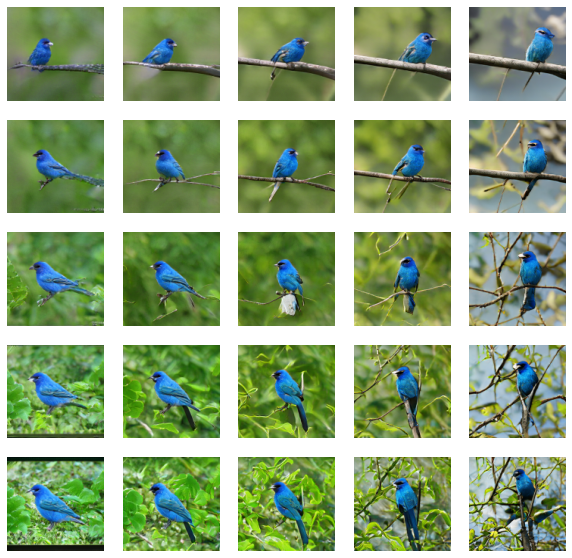

In [18]:
z_vectors = randomize()
display_gallery(generator, z_vectors, class_vector)

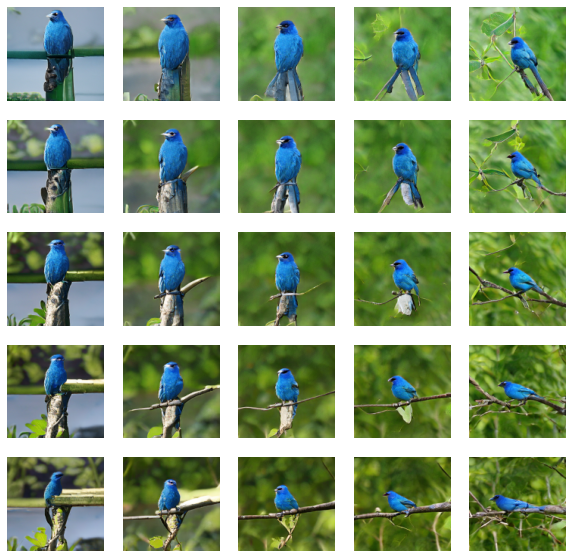

In [19]:
z_vectors = get_snapshot(category, 'snapshot1')
display_gallery(generator, z_vectors, class_vector)

### Selecting Images
One of the goals of interactive GAN model exploration is to select latent vectors $\mathbf{z}$ that result in photo-realistic images to generate representative galleries.

In [20]:
def select_sample(category, z_vectors, sample_idx, rows=5, cols=5):
    if category not in select_samples:
        select_samples[category] = []
        
    select_samples[category].append(z_vectors[get_index_of(sample_idx[0], sample_idx[1], rows, cols)])
        
    return z_vectors

In [21]:
def create_sample_gallery():
    
    sample_rows = 0
    sample_cols = 0
    sample_z_vectors = []
    sample_class_vector = []
    
    for category in select_samples:
        for z_vector in select_samples[category]:
            sample_z_vectors.append(z_vector)
            sample_class_vector.append(category)
    
    # Calculate gallery size. This is a very naive implementation.
    for i in range(5,0,-1):
        if len(sample_z_vectors) % i == 0:
            sample_cols = i
            sample_rows = len(sample_z_vectors) // sample_cols
            break
    
    return np.asarray(sample_z_vectors), one_hot_from_names(sample_class_vector, batch_size=len(sample_class_vector)), sample_rows, sample_cols

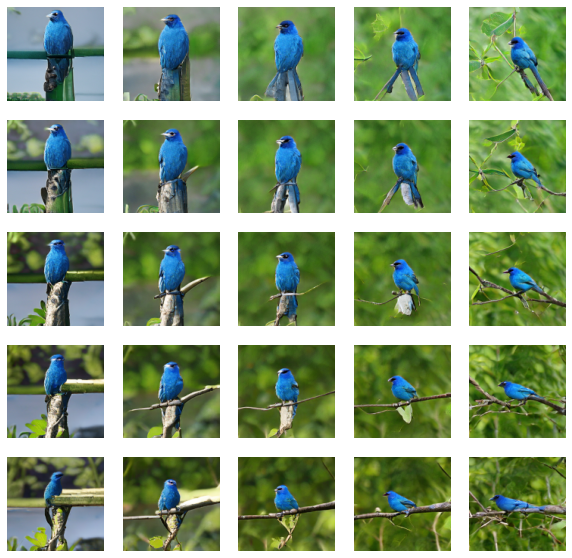

In [22]:
z_vectors = select_sample(category, z_vectors, (4, 4))
display_gallery(generator, z_vectors, class_vector)

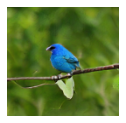

In [23]:
sample_z_vectors, sample_class_vector, sample_rows, sample_cols = create_sample_gallery()
display_gallery(generator, sample_z_vectors, sample_class_vector, sample_rows, sample_cols)

Use the next cell to explore the model and locate more photo-realistic images, then use the create_sample_gallery() and display_gallery() functions to display samples that you have collected.

In [24]:
# TODO: add one or more cells in which you will use the interactions we covered so far to explore the model and select photo-realistic images. Use the select_sample() function to select images. Then run the cell below to show your gallery.

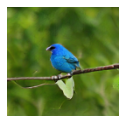

In [25]:
sample_z_vectors, sample_class_vector, sample_rows, sample_cols = create_sample_gallery()
display_gallery(generator, sample_z_vectors, sample_class_vector, sample_rows, sample_cols)

## Zoom into Region
At times, the user might encounter a working image gallery that contains a set of promissing images in a certain sub-region of the gallery. The user may want to then explore that particular region. Let's see how we can implement an interaction that supports this.

Mathematically, let the current working gallery be defined by a plane region $\mathcal{P}$, and let the vectors of latent variables corresponding to the top-left and bottom-right images in the zoom in region be $\mathbf{z_i}$ and $\mathbf{z_j}$, respectively. To construct the resulting working gallery plane region $\mathcal{P'}$ by computing vectors $\mathbf{c'},\mathbf{u'},\mathbf{v'}$ using the following equations:

\begin{equation}
    \mathbf{c'}=\frac{\mathbf{z_i}+\mathbf{z_j}}{2}
\end{equation}
\begin{equation}
    \mathbf{u'}=\frac{\mathbf{z_i}-\mathbf{z_j}}{2}
\end{equation}
\begin{equation}\label{v-before-norm}
    \mathbf{v'}=\frac{\left\|\mathbf{u'}\right\|}{\left\|\mathbf{v_1}-\mathbf{v_2}\right\|} (\mathbf{v_1}-\mathbf{v_2})
\end{equation}
where 
\begin{gather*}
    \mathbf{v_1}=\mathbf{z_i}-2\mathbf{z_j} \\
    \mathbf{v_2}=\frac{\mathbf{v_1}\cdot \mathbf{u'}}{\mathbf{u'}\cdot \mathbf{u'}}\mathbf{u'}
\end{gather*}

In the equation above, $\mathbf{v_1}-\mathbf{v_2}$ is the vector rejection of $\mathbf{v_1}$ from $\mathbf{u'}$, where $\mathbf{v_1}-\mathbf{v_2}$ ensures that $\mathbf{v'}$ is perpendicular to $\mathbf{u'}$, while the $\frac{\left\|\mathbf{u'}\right\|}{\left\|\mathbf{v_1}-\mathbf{v_2}\right\|}$ term scales the vector so that $\left\|\mathbf{u'}\right\|=\left\|\mathbf{v'}\right\|$. Our choice of $\mathbf{v_1}$ ensures that $\mathbf{v_1} \nparallel \mathbf{u'}$ (otherwise, $\mathbf{v'}$ would become zero), while $\mathbf{v_2}$ computes the vector projection of $\mathbf{v_1}$ from $\mathbf{u'}$. Note that this operation does not change the "orientation" of the resulting plane region.

In this implementation, the resulting plane region is always square, even if the zoom-in-region in the interface is rectangular:

<div>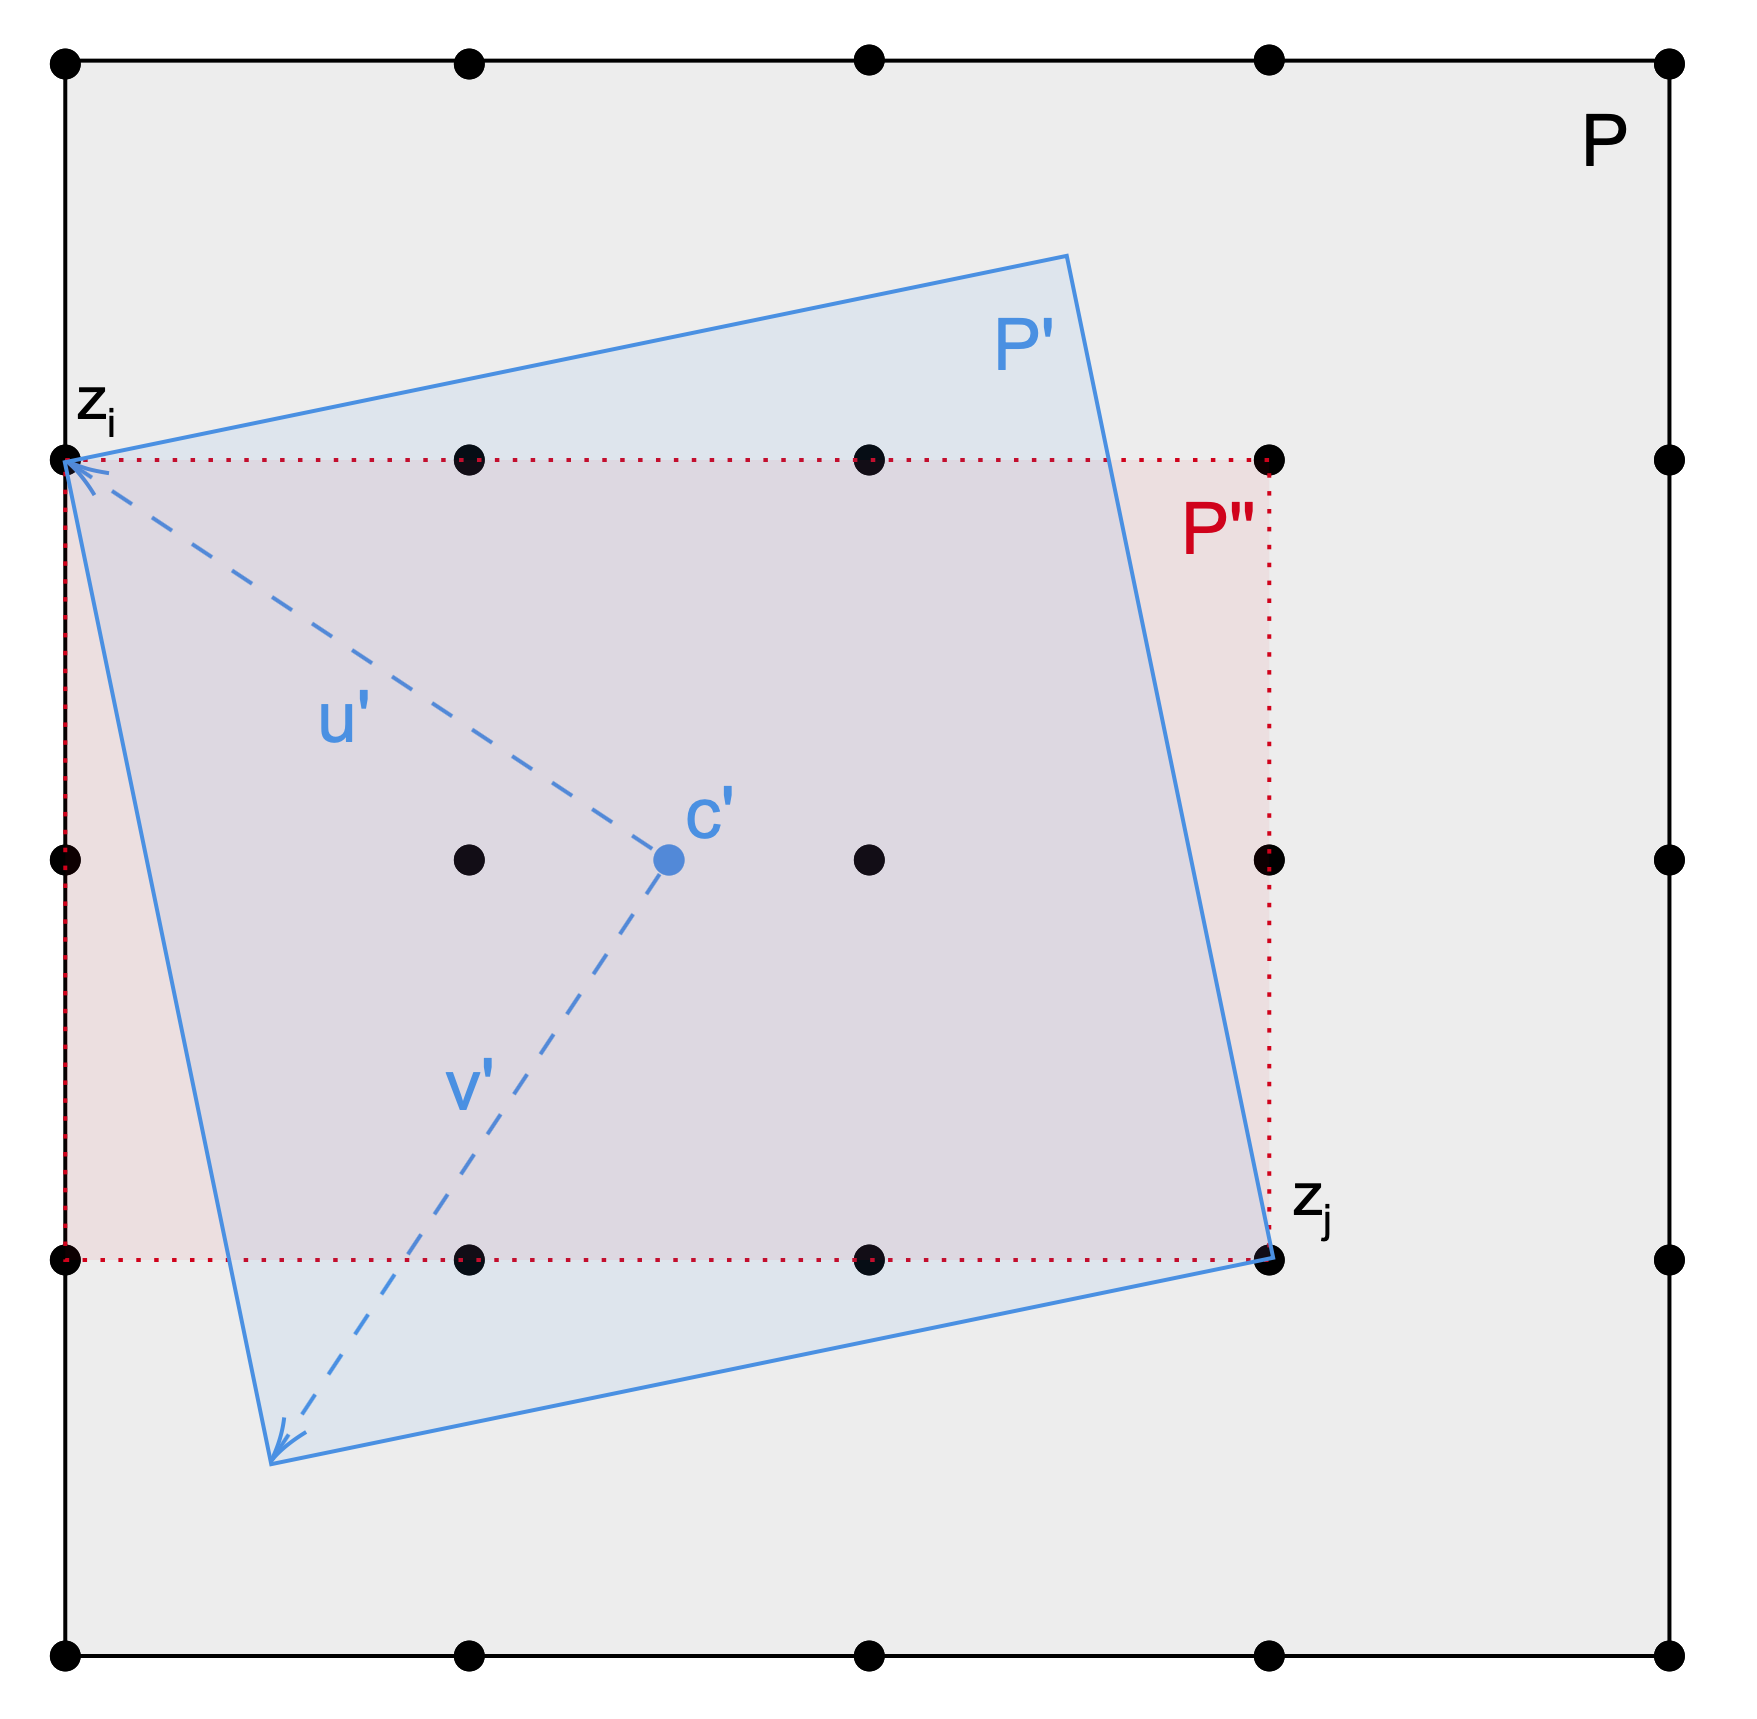</div>

In [26]:
def zoom_into_region(z_vectors, start_idx, end_idx, truncation=0.04, num_dims = 10, rows=5, cols=5):

    sampling_points = compute_sampling_points(z_vectors, tune_idxs)
    
    point1 = sampling_points[get_index_of(start_idx[0], start_idx[1], rows, cols)]
    point2 = sampling_points[get_index_of(end_idx[0], end_idx[1], rows, cols)]
    
    c = (point1 + point2) / 2
    u = point1 - point2
    u /= np.linalg.norm(u)

    v = point1 - 2 * point2 
    v -= v.dot(u) * u
    v /= np.linalg.norm(v)

    zoom_level = math.log(30 / np.linalg.norm(point2 - point1), 1.2)

    sampling_points = sampling_from_plane(c, u, v) 

    z_vectors = compute_z_vectors(sampling_points, base_vector, tune_idxs)
    
    return z_vectors, zoom_level

Let's refresh our memory about our current working gallery, so that we do not have to scroll up.

In [ ]:
display_gallery(generator, z_vectors, class_vector)

Now select a region you want to zoom into. What do you notice about the resulting image gallery?

In [ ]:
z_vectors, zoom_level = zoom_into_region(z_vectors, (1,4), (4,5))
display_gallery(generator, z_vectors, class_vector)

The images in the top-left and bottom-right corners of the resulting gallery are the images that bounded your region.

### Zoom In and Out
To explore the search space around a particular image of interest in the current working gallery, the user should be able to zoom in or zoom out of the current gallery centered at an image. The resulting working gallery will have the image that the user zoomed in or out of in the center and it will be surrounded by images that are more similar to it than the images in the current working gallery. Note, however, that zoom out is not a simple "undo" of the zoom in (and vice versa) because the user could use other tools after zooming into an image, or zoom out of an image that the user has not previously zoomed into.

In [ ]:
def zoom(z_vectors, zoom_idx, direction, truncation=0.04, num_dims = 10, rows=5, cols=5):
    optimizer = pySequentialLineSearch.SequentialLineSearchOptimizer(num_dims=num_dims)
    optimizer.set_hyperparams(kernel_signal_var=0.50,
                        kernel_length_scale=0.10,
                        kernel_hyperparams_prior_var=0.10) 

    new_zoom_level = zoom_level + 1 if direction == "in" else zoom_level - 1
    
    sampling_points = compute_sampling_points(z_vectors, tune_idxs)

    c = sampling_points[pick_idx].reshape(-1, 1)
    
    remove_x_preferable = np.delete(sampling_points, zoom_idx, 0)
    xs_other = [remove_x_preferable[i].reshape(-1, 1) for i in range(remove_x_preferable.shape[0])]

    # Update Gaussian process with existing samples
    optimizer.submit_line_search_result(c, xs_other)
    
    # Obtain next sampling point from the acquisition function (expected_improvement)
    X_EI = propose_location(expected_improvement, optimizer, bounds, num_dims)

    u = X_EI - c
    
    # Next, compute v_next
    v = propose_location_plane_version(c, u, expected_improvement_plane_version, optimizer, bounds, new_zoom_level, num_dims)

    sampling_points = sampling_from_plane(c, u, v) 

    z_vectors = compute_z_vectors(sampling_points, base_vector, tune_idxs)
    
    return z_vectors, zoom_level

In [ ]:
z_vectors, zoom_level = zoom(z_vectors, (3, 3), 'in')
display_gallery(generator, z_vectors, class_vector)

## Your Turn!
Now it is time for you to think of an interaction that you think would help you explore this model. Think about the image gallery paradigm and how you can manipulate the lens onto the model. Feel free to modify the rest of this notebook and implement as many functions that you need. Test and showecase your function, then select some images. We will have an opportunity to show your work at the end of the session.

In [ ]:
# TODO: your code starts here.

## References
Enhao Zhang and Nikola Banovic. 2021. Method for Exploring Generative Adversarial Networks (GANs) via Automatically Generated Image Galleries. In <i>Proceedings of the 2021 CHI Conference on Human Factors in Computing Systems</i> (<i>CHI '21</i>). Association for Computing Machinery, New York, NY, USA, Article 76, 1–15. https://doi.org/10.1145/3411764.3445714

Yuki Koyama, Issei Sato, and Masataka Goto. 2020. Sequential gallery for interactive visual design optimization. <i>ACM Trans. Graph.</i> 39, 4, Article 88 (August 2020), 12 pages. https://doi.org/10.1145/3386569.3392444